# Setup

Here, we already imported most of the packages that you might want to use

In [12]:
import os
import pandas as pd

In [51]:
import pm4py

## Log Util
# Log conversion
from pm4py.objects.conversion.log import converter as log_converter
# Read Log (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.obj import EventLog
from pm4py.objects.log.util.log import get_event_labels
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.log.variants import variants_filter

## Conformance Checking
# Token-based replay (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
# Standard Alignments (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.algo.conformance.alignments import algorithm as alignments
# Footprint
from pm4py.algo.conformance.footprints import algorithm as footprints_conformance
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery

from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

## Petri Nets
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils import petri_utils, check_soundness
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

## Decision Trees
from sklearn import tree
from pm4py.visualization.decisiontree import visualizer as dectree_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
from pm4py.objects.log.util import get_class_representation

# Hints
**Have look at the simplified interface of PM4Py $\rightarrow$ Click on the 'See Simplified Interface' buttons on the documentation page**

Good way to convert a DataFrame so that it works nicely in PM4Py
```python
df = pm4py.format_dataframe(df, case_id=case_id_column activity_key=activity_column, timestamp_key=timestamp_column)
```

If you do not have ipywidgets installed, you'll probably encounter the ```IProgress not found``` error.
In that case, it should help to deactivate the progress bar by passing a dictionary with the following key:
```python
{'show_progress_bar': False}
```
However, currently you can not use the simplified interface then. Instead you have to use the base functions.
For example, for importing a log without progress bar, you can use
```
log = xes_importer.apply('log.xes',parameters={'show_progress_bar':False})
```
If you have ipywidgets installed
```python
log = pm4py.read_xes(file_path)
```
can be used.

In [14]:
log = pm4py.read_xes("logs/log_vaccination.xes")

parsing log, completed traces ::   0%|          | 0/4960 [00:00<?, ?it/s]

# Process Overview

In [15]:
# input: event log
# output: statistics (Dict) and duration of cases (List)
def getDataFromEventLog(event_log): 
    # number of cases in the event log
    case_num = len(event_log)
    # print(Case_num)
    # initialization
    activities = set()  # use set to get different activities
    # number of event
    total_Event_num = 0 
    # start of the log
    start = None
    # end of the log
    end = None  
    # max number of events of each trace
    max_Event_num = 0  
    # min number of events of each trace
    min_Event_num = 0x3f3f3f3f  
    # average number of events of each trace
    avg_Event_num = 0 
    # total number of events of each trace
    total_Event_num = 0
    # max duration of each trace
    max_Duration = None  
    # min duration of each trace
    min_Duration = None  
    # average duration of each trace
    avg_Duration = None  
    # total duration of each trace
    total_Duration = None
    # list to store duration of each trace
    list_duration = []
    
    for i in range(len(event_log)):
        # get the current trace
        trace = event_log[i] 
        # number of events of this trace
        trace_len = len(trace) 
        if max_Event_num < trace_len: 
            max_Event_num = trace_len
        if min_Event_num > trace_len: 
            min_Event_num = trace_len
        total_Event_num = total_Event_num + trace_len
        # the earliest timestamp
        start_time = None
        # the latest timestamp
        end_time = None
        for j in range(len(trace)):
            event = trace[j]
            activity = None
            try:
                activity = event["concept:name"]
            except:
                pass
            if activity is not None:
                activities.add(activity)
            try:
                date_timestamp = event["time:timestamp"]
            except:
                continue
            if start_time is None: 
                start_time = date_timestamp
            end_time = date_timestamp
        if start_time is not None:
            if start is None:
                start = start_time
            else:
                if start > start_time:
                    start = start_time
        if end_time is not None:
            if end is None:
                end = end_time
            else:
                if end < end_time:
                    end = end_time
        # get the duration of the trace from the difference of the start and end time
        try:
            duration = end_time - start_time 
        except:
            continue
        # find the max, min and average number of events for the current trace
        if max_Duration is None:
            max_Duration = duration
        else:
            if max_Duration < duration:
                max_Duration = duration
        if min_Duration is None:
            min_Duration = duration
        else:
            if min_Duration > duration:
                min_Duration = duration
        if total_Duration is None:
            total_Duration = duration
        else:
            total_Duration = total_Duration + duration
        list_duration.append(round(duration.total_seconds() / 3600, 2))
    
    activities_num = len(activities)  
    
    avg_Duration = total_Duration / case_num  
    avg_Event_num = round(total_Event_num / case_num, 2)  # round 2 decimal
    # convert timedelta objects to seconds
    max_Duration = round(max_Duration.total_seconds() / 3600, 2)
    min_Duration = round(min_Duration.total_seconds() / 3600, 2)
    avg_Duration = round(avg_Duration.total_seconds() / 3600, 2)
    
    overview_log = {}
    overview_log['Number of Cases'] = [case_num]
    overview_log['Type of Activities'] = activities
    overview_log['Number of Activities'] = [activities_num]
    overview_log['Number of Events'] = [total_Event_num]
    overview_log['Start Date'] = [start]
    overview_log['End Date'] = [end]
    overview_log['Max_Number_Events'] = [max_Event_num]
    overview_log['Min_Number_Events'] = [min_Event_num]
    overview_log['Avg_Number_Events'] = [avg_Event_num]
    overview_log['Max_Case_Duration (in hours)'] = [max_Duration]
    overview_log['Min_Case_Duration (in hours)'] = [min_Duration]
    overview_log['Avg_Case_Duration (in hours)'] = [avg_Duration]
    
    return overview_log, list_duration

In [16]:
overviewlog,all_durations = getDataFromEventLog(log)
overviewlog

{'Number of Cases': [4960],
 'Type of Activities': {'Acknowledge vacc. possibility',
  'Appointment granted',
  'Checkout',
  'Checkout No Vacc',
  'Decline vaccination',
  'Destroy Vacc',
  'Enter into System',
  'Finished Risk Talk',
  'Insurance Check Private',
  'Insurance Check Statutory',
  'Notify about vacc. possibility',
  'Prepare vaccine',
  'Priority Appointment granted',
  'Register at vaccination facillity',
  'Request appointment',
  'Send Invoice',
  'Send Vaccination Certificate',
  'Send vaccine to cabine',
  'Submit Declaration',
  'Vaccinate'},
 'Number of Activities': [20],
 'Number of Events': [92949],
 'Start Date': [datetime.datetime(2021, 1, 27, 6, 0, 1, tzinfo=datetime.timezone.utc)],
 'End Date': [datetime.datetime(2022, 4, 21, 18, 19, 51, tzinfo=datetime.timezone.utc)],
 'Max_Number_Events': [35],
 'Min_Number_Events': [3],
 'Avg_Number_Events': [18.74],
 'Max_Case_Duration (in hours)': [7806.85],
 'Min_Case_Duration (in hours)': [0.42],
 'Avg_Case_Duration 

Text(0.5, 1.0, 'Distribution of Duration')

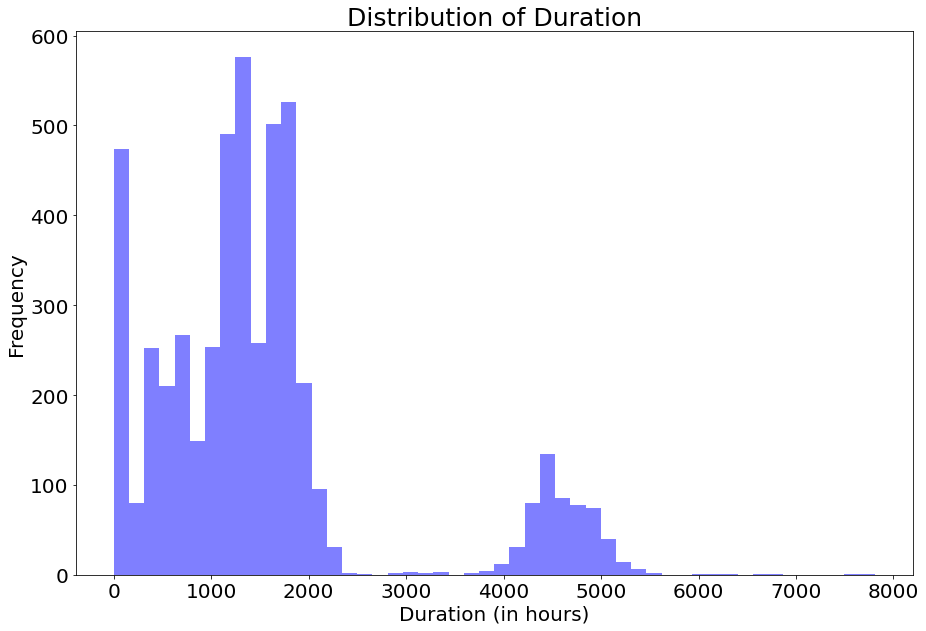

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.hist(all_durations, bins=50, facecolor="blue", alpha=0.5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Duration (in hours)", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.title("Distribution of Duration", fontsize=25)

# Process Discovery

In [18]:
import sys
# four quality dimensions for several discovered models
# input: event log; petri net resulted from process discovery model; initial marking; final marking
# output: dictionary including replay-fitness, precision, generalization, simplicity for token-based and alignment
def qualityDim4Model(event_log, net, im, fm):
    model = {}
    model["Token_based"]={}
    model["Alignments"]={}
    
    # token-based replay
    replayed_traces = token_replay.apply(event_log, net, im, fm)
    
    token_fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
    token_precision = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
    token_gen = generalization_evaluator.apply(event_log, net, im, fm)
    token_simp = simplicity_evaluator.apply(net)
    
    model["Token_based"]["fitness"] = token_fitness
    model["Token_based"]["precision"] = token_precision
    model["Token_based"]["generalization"] = token_gen
    model["Token_based"]["simplicity"] = token_simp
    print("Tokedn-based:")
    print(model["Token_based"])
    
    # alignments
    try:
        aligned_traces = alignments.apply_log(event_log, net, im, fm)
        aligned_fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
        aligned_precision = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
    
        model["Alignments"]["fitness"] = aligned_fitness
        model["Alignments"]["precision"] = aligned_precision
        print(model["Alignments"])
    except:
        info=sys.exc_info()
        print("Alignments:")
        print(info[0],":",info[1])
    
    return model

In [19]:
eventlog_2b = xes_importer.apply('logs/log_vaccination_finished_cases.xes')

parsing log, completed traces ::   0%|          | 0/3978 [00:00<?, ?it/s]

Q2b: Inductive miner

In [21]:
net, im, fm = pnml_importer.apply("petriNet/petriNets_2b/inductiveMiner_PetriNet_2b.pnml")
inductiveMiner_2b = qualityDim4Model(event_log=eventlog_2b, net=net, im=im,fm=fm)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 44.947209653092, 'average_trace_fitness': 0.9364111504259774, 'log_fitness': 0.9655188601741661, 'percentage_of_fitting_traces': 44.947209653092}, 'precision': 0.9193824338566403, 'generalization': 0.9370631958708733, 'simplicity': 0.7959183673469388}


aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

{'fitness': {'percFitTraces': 44.947209653092, 'averageFitness': 0.9243185691210299, 'percentage_of_fitting_traces': 44.947209653092, 'average_trace_fitness': 0.9243185691210299, 'log_fitness': 0.9454665678533255}, 'precision': 0.9201002684784395}


Q2b: Heuristic Miner

In [24]:
net, im, fm = pnml_importer.apply("petriNet/petriNets_2b/heuristicMiner_PetriNet_2b.pnml")
heuristicMiner_2b = qualityDim4Model(event_log=eventlog_2b, net=net, im=im,fm=fm)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 1.231774761186526, 'average_trace_fitness': 0.953412835282751, 'log_fitness': 0.9668087402958637, 'percentage_of_fitting_traces': 1.231774761186526}, 'precision': 0.7994377430187345, 'generalization': 0.9321751463398074, 'simplicity': 0.6645962732919255}


aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

{'fitness': {'percFitTraces': 1.231774761186526, 'averageFitness': 0.8028882378340877, 'percentage_of_fitting_traces': 1.231774761186526, 'average_trace_fitness': 0.8028882378340877, 'log_fitness': 0.8280017670980915}, 'precision': 0.7994377430187345}


Q2b: Alpha Miner

In [25]:
net, im, fm = pnml_importer.apply("petriNet/petriNets_2b/alphaMiner_PetriNet_2b.pnml")
alphaMiner_2b = qualityDim4Model(event_log=eventlog_2b, net=net, im=im,fm=fm)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.7708127690354911, 'log_fitness': 0.7714294195030039, 'percentage_of_fitting_traces': 0.0}, 'precision': 0.39945487583282857, 'generalization': 0.9726607495900866, 'simplicity': 0.39860139860139865}
Alignments:
<class 'Exception'> : trying to apply alignments on a Petri net that is not a easy sound net!!


Q2b: ILP Miner

In [26]:
net, im, fm = pnml_importer.apply("petriNet/petriNets_2b/ILPMiner_PetriNet_2b.pnml")
ILPMiner_2b = qualityDim4Model(event_log=eventlog_2b, net=net, im=im,fm=fm)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 31.171442936148818, 'average_trace_fitness': 0.9305937751586801, 'log_fitness': 0.9651466999726177, 'percentage_of_fitting_traces': 31.171442936148818}, 'precision': 0.9101640185616834, 'generalization': 0.984556526756547, 'simplicity': 0.2510288065843621}


aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

{'fitness': {'percFitTraces': 31.171442936148818, 'averageFitness': 0.8372796139636088, 'percentage_of_fitting_traces': 31.171442936148818, 'average_trace_fitness': 0.8372796139636088, 'log_fitness': 0.8835309392382467}, 'precision': 0.937179346031047}


Q2b: State Region Miner

In [27]:
net, im, fm = pnml_importer.apply("petriNet/petriNets_2b/stateRegionMiner_PetriNet_2b.pnml")
stateRegionMiner_2b = qualityDim4Model(event_log=eventlog_2b, net=net, im=im,fm=fm)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9280559733066965, 'log_fitness': 0.9547606163553362, 'percentage_of_fitting_traces': 0.0}, 'precision': 0.5406270755559628, 'generalization': 0.8834153118172494, 'simplicity': 0.47368421052631576}
Alignments:
<class 'Exception'> : trying to apply alignments on a Petri net that is not a easy sound net!!


Q2c:

In [28]:
#import the filtered log from disco
q2c = pm4py.read_xes("logs/2c.xes.gz")
df_q2c = pm4py.convert_to_dataframe(q2c)
df_q2c

parsing log, completed traces ::   0%|          | 0/3316 [00:00<?, ?it/s]

,lifecycle:transition,time:timestamp,concept:name,case:concept:name,case:variant,case:variant-index,case:creator,case:Patient,case:Age,case:Insurance,case:HealthWorker
0,complete,2021-01-27 07:00:01+01:00,Enter into System,95,Variant 1,1,Fluxicon Disco,95,27,PRIV,true
1,complete,2021-01-27 10:12:41+01:00,Notify about vacc. possibility,95,Variant 1,1,Fluxicon Disco,95,27,PRIV,true
2,complete,2021-02-03 11:21:26+01:00,Acknowledge vacc. possibility,95,Variant 1,1,Fluxicon Disco,95,27,PRIV,true
3,complete,2021-02-05 01:36:22+01:00,Request appointment,95,Variant 1,1,Fluxicon Disco,95,27,PRIV,true
4,complete,2021-02-08 13:40:00+01:00,Register at vaccination facillity,95,Variant 1,1,Fluxicon Disco,95,27,PRIV,true
...,...,...,...,...,...,...,...,...,...,...,...
37756,complete,2022-01-09 14:14:51+01:00,Checkout,4854,Variant 1,1,Fluxicon Disco,4854,30,PRIV,0
37757,complete,2022-01-31 11:40:00+01:00,Register at vaccination facillity,4854,Variant 1,1,Fluxicon Disco,4854,30,PRIV,0
37758,complete,2022-01-31 11:45:17+01:00,Submit Declaration,4854,Variant 1,1,Fluxicon Disco,4854,30,PRIV,0
37759,complete,2022-01-31 11:49:57+01:00,Vaccinate,4854,Variant 1,1,Fluxicon Disco,4854,30,PRIV,0


In [29]:
df_q2c.loc[df_q2c['concept:name']=='Checkout No Vacc'] = 'Decline vaccination'

In [30]:
df_q2c['concept:name'].unique()

array(['Enter into System', 'Notify about vacc. possibility',
       'Acknowledge vacc. possibility', 'Request appointment',
       'Register at vaccination facillity', 'Finished Risk Talk',
       'Submit Declaration', 'Vaccinate', 'Checkout',
       'Decline vaccination'], dtype=object)

Q2d: Inductive Miner

In [31]:
# 2d
eventlog_2d = xes_importer.apply('logs/log_vaccination_2c.xes')

parsing log, completed traces ::   0%|          | 0/3316 [00:00<?, ?it/s]

In [32]:
net, im, fm = pnml_importer.apply("petriNet/petriNets_2d/inductiveMiner_2d.pnml")
inductiveMiner_2d = qualityDim4Model(event_log=eventlog_2d, net=net, im=im,fm=fm)

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 9.529553679131483, 'average_trace_fitness': 0.7596972411148265, 'log_fitness': 0.7853234271217948, 'percentage_of_fitting_traces': 9.529553679131483}, 'precision': 0.8558779876145146, 'generalization': 0.9811984996086338, 'simplicity': 0.8285714285714286}


aligning log, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

{'fitness': {'percFitTraces': 9.529553679131483, 'averageFitness': 0.7659465140413931, 'percentage_of_fitting_traces': 9.529553679131483, 'average_trace_fitness': 0.7659465140413931, 'log_fitness': 0.7832892194938902}, 'precision': 0.8558779876145146}


Q2d: Heuristic Miner

In [33]:
net, im, fm = pnml_importer.apply("petriNet/petriNets_2d/heuristicMiner_2d.pnml")
heuristicMiner_2d = qualityDim4Model(event_log=eventlog_2d, net=net, im=im,fm=fm)

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9444416428071021, 'log_fitness': 0.9565828974785221, 'percentage_of_fitting_traces': 0.0}, 'precision': 0.6970611631125301, 'generalization': 0.8563179483247065, 'simplicity': 0.6944444444444444}
Alignments:
<class 'Exception'> : trying to apply alignments on a Petri net that is not a easy sound net!!


Q2d: Alpha Miner

In [34]:
net, im, fm = pnml_importer.apply("petriNet/petriNets_2d/alphaMiner_2d.pnml")
alphaMiner_2d = qualityDim4Model(event_log=eventlog_2d, net=net, im=im,fm=fm)

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.7442451914296937, 'log_fitness': 0.7298860100733704, 'percentage_of_fitting_traces': 0.0}, 'precision': 0.4484874127353501, 'generalization': 0.9812523659063134, 'simplicity': 0.5111111111111112}
Alignments:
<class 'Exception'> : trying to apply alignments on a Petri net that is not a easy sound net!!


Q2d: ILP Miner

In [35]:
net, im, fm = pnml_importer.apply("petriNet/petriNets_2d/ILPMiner_2d.pnml")
ILPMiner_2d = qualityDim4Model(event_log=eventlog_2d, net=net, im=im,fm=fm)

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 70.71773220747889, 'average_trace_fitness': 0.9379639116354035, 'log_fitness': 0.9750264253600328, 'percentage_of_fitting_traces': 70.71773220747889}, 'precision': 0.9989932974805945, 'generalization': 0.9835588712474141, 'simplicity': 0.3333333333333333}


aligning log, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

{'fitness': {'percFitTraces': 70.71773220747889, 'averageFitness': 0.8925988025299624, 'percentage_of_fitting_traces': 70.71773220747889, 'average_trace_fitness': 0.8925988025299624, 'log_fitness': 0.9315195949442294}, 'precision': 0.9993639519783744}


Q2d: State Region Miner

In [36]:
net, im, fm = pnml_importer.apply("petriNet/petriNets_2d/stateRegionMiner_2d.pnml")
stateRegionMiner_2d = qualityDim4Model(event_log=eventlog_2d, net=net, im=im,fm=fm)

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/283 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/88 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.930545382446684, 'log_fitness': 0.9434308856403903, 'percentage_of_fitting_traces': 0.0}, 'precision': 0.838199831888771, 'generalization': 0.8828632373237021, 'simplicity': 0.6000000000000001}
Alignments:
<class 'Exception'> : trying to apply alignments on a Petri net that is not a easy sound net!!


In [37]:
# 2e
# threshold = [0.0, 0.3, 0.6, 0.9]
from pm4py.algo.discovery.inductive import parameters
inductiveMiner_2e = {}
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

G:\Anaconda\envs\env-IDS2021\lib\site-packages\pm4py\algo\discovery\inductive\parameters.py:22: UserWarning: pm4py.algo.discovery.inductive.parameters is deprecated. Please use the variant-specific parameters!
  warnings.warn("pm4py.algo.discovery.inductive.parameters is deprecated. Please use the variant-specific parameters!")


Q2e: threshold = 0.0

In [38]:
net_2e, initial_marking_2e, final_marking_2e = inductive_miner.apply(eventlog_2b,parameters={parameters.Parameters.NOISE_THRESHOLD:0})
inductiveMiner_2e["0.0"] = qualityDim4Model(event_log=eventlog_2b, net=net_2e, im=initial_marking_2e, fm=final_marking_2e)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.19541776243088327, 'generalization': 0.9366132569220332, 'simplicity': 0.6164383561643836}


aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

{'fitness': {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.999801866209956}, 'precision': 0.19541776243088327}


Q2e: threshold = 0.3

In [43]:
net_2e, initial_marking_2e, final_marking_2e = inductive_miner.apply(eventlog_2b,parameters={parameters.Parameters.NOISE_THRESHOLD:0.3})
inductiveMiner_2e["0.3"] = qualityDim4Model(event_log=eventlog_2b, net=net_2e, im=initial_marking_2e, fm=final_marking_2e)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.19541776243088327, 'generalization': 0.9366132569220332, 'simplicity': 0.6164383561643836}


aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

{'fitness': {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.999801866209956}, 'precision': 0.19541776243088327}


Q2e: threshold = 0.6

In [45]:
net_2e, initial_marking_2e, final_marking_2e = inductive_miner.apply(eventlog_2b,parameters={parameters.Parameters.NOISE_THRESHOLD:0.6})
inductiveMiner_2e["0.6"] = qualityDim4Model(event_log=eventlog_2b, net=net_2e, im=initial_marking_2e, fm=final_marking_2e)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.19541776243088327, 'generalization': 0.9366132569220332, 'simplicity': 0.6164383561643836}


aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

{'fitness': {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.999801866209956}, 'precision': 0.19541776243088327}


Q2e: threshold = 0.9

In [46]:
net_2e, initial_marking_2e, final_marking_2e = inductive_miner.apply(eventlog_2b,parameters={parameters.Parameters.NOISE_THRESHOLD:0.9})
inductiveMiner_2e["0.9"] = qualityDim4Model(event_log=eventlog_2b, net=net_2e, im=initial_marking_2e, fm=final_marking_2e)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

Tokedn-based:
{'fitness': {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}, 'precision': 0.19541776243088327, 'generalization': 0.9366132569220332, 'simplicity': 0.6164383561643836}


aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

{'fitness': {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.999801866209956}, 'precision': 0.19541776243088327}


# Conformance Checking

Q3a

In [47]:
log_q3 = pm4py.read_xes("logs/log_vaccination_finished_cases.xes")

parsing log, completed traces ::   0%|          | 0/3978 [00:00<?, ?it/s]

In [48]:
#inductive miner from Q2
net_i, im_i, fm_i = pnml_importer.apply("petriNet/petriNets_2b/inductiveMiner_PetriNet_2b.pnml")
fp_log = footprints_discovery.apply(log_q3, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
fp_trace_by_trace = footprints_discovery.apply(log_q3, variant=footprints_discovery.Variants.TRACE_BY_TRACE)
fp_net = footprints_discovery.apply(net_i, im_i, fm_i)
#fp_net

print(len(fp_net['sequence']))
print(len(fp_net['parallel']))

22
0


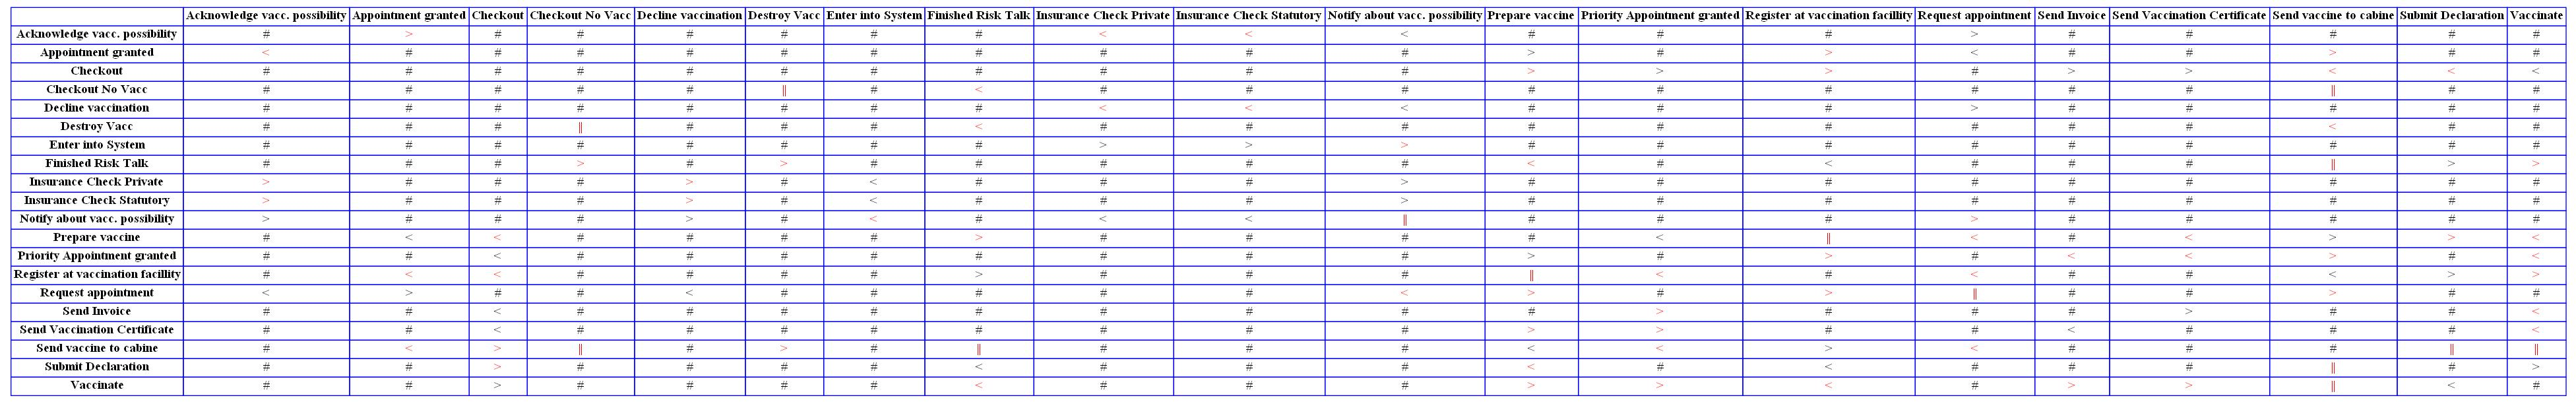

In [49]:
#compare the two footprint tables, the deviations are colored by red
from pm4py.visualization.footprints import visualizer as fp_visualizer

gviz = fp_visualizer.apply(fp_log, fp_net, parameters={fp_visualizer.Variants.COMPARISON.value.Parameters.FORMAT: "jpg"})
fp_visualizer.view(gviz)

In [52]:
conf_fp = footprints_conformance.apply(fp_trace_by_trace, fp_net)
conf_fp

[set(),
 {('Notify about vacc. possibility', 'Notify about vacc. possibility')},
 {('Insurance Check Private', 'Acknowledge vacc. possibility'),
  ('Request appointment', 'Request appointment')},
 {('Send Vaccination Certificate', 'Priority Appointment granted')},
 {('Insurance Check Private', 'Acknowledge vacc. possibility')},
 {('Prepare vaccine', 'Submit Declaration'),
  ('Priority Appointment granted', 'Register at vaccination facillity'),
  ('Register at vaccination facillity', 'Prepare vaccine'),
  ('Request appointment', 'Request appointment'),
  ('Send vaccine to cabine', 'Vaccinate'),
  ('Submit Declaration', 'Send vaccine to cabine')},
 set(),
 {('Send Vaccination Certificate', 'Priority Appointment granted')},
 set(),
 set(),
 {('Destroy Vacc', 'Checkout No Vacc'),
  ('Finished Risk Talk', 'Destroy Vacc')},
 set(),
 {('Prepare vaccine', 'Register at vaccination facillity')},
 {('Checkout', 'Prepare vaccine'),
  ('Send Vaccination Certificate', 'Priority Appointment granted')

47
0


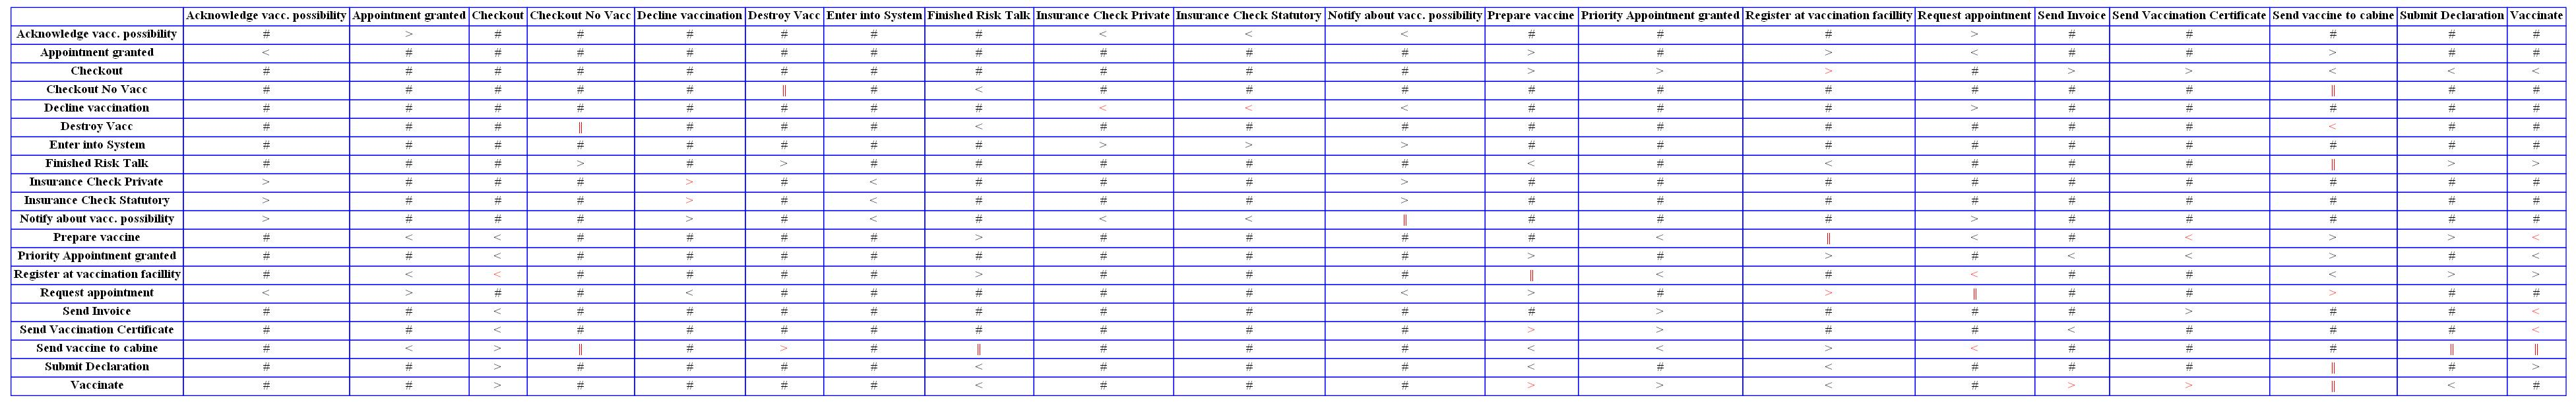

In [53]:
#heuristic miner from Q2
net, im, fm = pnml_importer.apply("petriNet/petriNets_2b/heuristicMiner_PetriNet_2b.pnml")
fp_log = footprints_discovery.apply(log_q3, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
fp_net = footprints_discovery.apply(net, im, fm)
#fp_net

print(len(fp_net['sequence']))
print(len(fp_net['parallel']))

#compare the two footprint tables, the deviations are colored by red
from pm4py.visualization.footprints import visualizer as fp_visualizer

gviz = fp_visualizer.apply(fp_log, fp_net, parameters={fp_visualizer.Variants.COMPARISON.value.Parameters.FORMAT: "jpg"})
fp_visualizer.view(gviz)

Q3b Full hand model

In [55]:
net_full, im_full, fm_full = pnml_importer.apply("models/full_hand.pnml")

footprint matrix

In [56]:
fp_log = footprints_discovery.apply(log_q3, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
fp_trace_trace = footprints_discovery.apply(log_q3, variant=footprints_discovery.Variants.TRACE_BY_TRACE)
fp_net = footprints_discovery.apply(net_full, im_full, fm_full)
fp_net

{'sequence': {('Acknowledge vacc. possibility', 'Request appointment'),
  ('Appointment granted', 'Prepare vaccine'),
  ('Checkout', 'Priority Appointment granted'),
  ('Checkout', 'Send Invoice'),
  ('Checkout', 'Send Vaccination Certificate'),
  ('Enter into System', 'Insurance Check Private'),
  ('Enter into System', 'Insurance Check Statutory'),
  ('Finished Risk Talk', 'Checkout No Vacc'),
  ('Finished Risk Talk', 'Destroy Vacc'),
  ('Finished Risk Talk', 'Submit Declaration'),
  ('Insurance Check Private', 'Notify about vacc. possibility'),
  ('Insurance Check Statutory', 'Notify about vacc. possibility'),
  ('Notify about vacc. possibility', 'Acknowledge vacc. possibility'),
  ('Notify about vacc. possibility', 'Decline vaccination'),
  ('Prepare vaccine', 'Send vaccine to cabine'),
  ('Priority Appointment granted', 'Prepare vaccine'),
  ('Register at vaccination facillity', 'Finished Risk Talk'),
  ('Register at vaccination facillity', 'Submit Declaration'),
  ('Request appoin

In [57]:
print(len(fp_net['sequence']))
print(len(fp_net['parallel']))

23
2


In [58]:
conf_result = footprints_conformance.apply(fp_log, fp_net, variant=footprints_conformance.Variants.LOG_EXTENSIVE)
conf_result

{'footprints': {('Acknowledge vacc. possibility', 'Appointment granted'),
  ('Appointment granted', 'Register at vaccination facillity'),
  ('Appointment granted', 'Send vaccine to cabine'),
  ('Checkout', 'Prepare vaccine'),
  ('Checkout', 'Register at vaccination facillity'),
  ('Checkout No Vacc', 'Send vaccine to cabine'),
  ('Decline vaccination', 'Request appointment'),
  ('Enter into System', 'Notify about vacc. possibility'),
  ('Finished Risk Talk', 'Send vaccine to cabine'),
  ('Finished Risk Talk', 'Vaccinate'),
  ('Insurance Check Private', 'Acknowledge vacc. possibility'),
  ('Insurance Check Private', 'Decline vaccination'),
  ('Insurance Check Statutory', 'Acknowledge vacc. possibility'),
  ('Insurance Check Statutory', 'Decline vaccination'),
  ('Notify about vacc. possibility', 'Notify about vacc. possibility'),
  ('Notify about vacc. possibility', 'Request appointment'),
  ('Prepare vaccine', 'Finished Risk Talk'),
  ('Prepare vaccine', 'Register at vaccination facill

In [59]:
from pm4py.algo.conformance.footprints.util import evaluation

fitness = evaluation.fp_fitness(fp_log, fp_net, conf_result)
precision = evaluation.fp_precision(fp_log, fp_net)

print(fitness)
print(precision)

0.9047722487656111
1.0


token-based replay

In [60]:
replayed_traces = token_replay.apply(log_q3, net_full, im_full, fm_full)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

In [61]:
fitness = replay_fitness_evaluator.apply(log_q3, net_full, im_full, fm_full, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(fitness)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

{'perc_fit_traces': 57.3403720462544, 'average_trace_fitness': 0.9620277900494425, 'log_fitness': 0.9695556239672888, 'percentage_of_fitting_traces': 57.3403720462544}


In [62]:
prec = precision_evaluator.apply(log_q3, net_full, im_full, fm_full, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(prec)

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

0.9656268598220377


alignements

In [63]:
aligned_traces = alignments.apply_log(log_q3, net_full, im_full, fm_full)
aligned_traces

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

[{'alignment': [('Enter into System', 'Enter into System'),
   ('Insurance Check Private', 'Insurance Check Private'),
   ('Notify about vacc. possibility', 'Notify about vacc. possibility'),
   ('Acknowledge vacc. possibility', 'Acknowledge vacc. possibility'),
   ('Request appointment', 'Request appointment'),
   ('Appointment granted', 'Appointment granted'),
   ('Prepare vaccine', 'Prepare vaccine'),
   ('Send vaccine to cabine', 'Send vaccine to cabine'),
   ('Register at vaccination facillity', 'Register at vaccination facillity'),
   ('Finished Risk Talk', 'Finished Risk Talk'),
   ('>>', None),
   ('Submit Declaration', 'Submit Declaration'),
   ('Vaccinate', 'Vaccinate'),
   ('Checkout', 'Checkout'),
   ('Priority Appointment granted', 'Priority Appointment granted'),
   ('Prepare vaccine', 'Prepare vaccine'),
   ('Send vaccine to cabine', 'Send vaccine to cabine'),
   ('Register at vaccination facillity', 'Register at vaccination facillity'),
   ('>>', None),
   ('Submit Decl

In [64]:
fitness = replay_fitness_evaluator.apply(log_q3, net_full, im_full, fm_full, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(fitness)

prec = precision_evaluator.apply(log_q3, net_full, im_full, fm_full, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(prec)

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

{'percFitTraces': 57.3403720462544, 'averageFitness': 0.958398330644705, 'percentage_of_fitting_traces': 57.3403720462544, 'average_trace_fitness': 0.958398330644705, 'log_fitness': 0.9598597978930206}


computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

0.9656268598220377


Q3c

In [66]:
net, im, fm = pnml_importer.apply("models/flower.pnml")
log_q3c = pm4py.read_xes("logs/one_trace_log.xes")

parsing log, completed traces ::   0%|          | 0/1 [00:00<?, ?it/s]

footprint

In [67]:
fp_log = footprints_discovery.apply(log_q3, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
fp_net = footprints_discovery.apply(net, im, fm)
conf_result = footprints_conformance.apply(fp_log, fp_net, variant=footprints_conformance.Variants.LOG_EXTENSIVE)

fitness = evaluation.fp_fitness(fp_log, fp_net, conf_result)
precision = evaluation.fp_precision(fp_log, fp_net)

print(fitness)
print(precision)

1.0
0.17


alignment

In [68]:
aligned_traces = alignments.apply_log(log_q3, net, im, fm)

fitness = replay_fitness_evaluator.apply(log_q3, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(fitness)

prec = precision_evaluator.apply(log_q3, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(prec)

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999890530526768}


computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

0.13261072966688225


In [69]:
#full_hand and one_trace_log
#token based
replayed_traces = token_replay.apply(log_q3c, net_full, im_full, fm_full)
fitness = replay_fitness_evaluator.apply(log_q3c, net_full, im_full, fm_full, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(fitness)
prec = precision_evaluator.apply(log_q3c, net_full, im_full, fm_full, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(prec)

{'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9333333333333333, 'log_fitness': 0.9333333333333333, 'percentage_of_fitting_traces': 0.0}


replaying log with TBR, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

0.5714285714285714


In [70]:
#alignments
fitness = replay_fitness_evaluator.apply(log_q3c, net_full, im_full, fm_full, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(fitness)

prec = precision_evaluator.apply(log_q3c, net_full, im_full, fm_full, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(prec)

{'percFitTraces': 0.0, 'averageFitness': 0.6206896551724138, 'percentage_of_fitting_traces': 0.0, 'average_trace_fitness': 0.6206896551724138, 'log_fitness': 0.6206853745836236}


computing precision with alignments, completed variants ::   0%|          | 0/24 [00:00<?, ?it/s]

0.5714285714285714


# Performance

In [71]:
#Q4c
eventlog_4c = pm4py.read_xes("logs/log_resources.xes")

parsing log, completed traces ::   0%|          | 0/4648 [00:00<?, ?it/s]

In [72]:
# generate the new attribute "illegal" for each trace
# if the trace contains "" and "Send Invoice"
# the attribute "illegal" values 1
# otherwise it values 0
for trace in eventlog_4c:
    trigger = -1
    activities = []
    for event in trace:
        activities.append(event['concept:name'])
#     print(activities)
    if 'Insurance Check Statutory' in activities and 'Send Invoice' in activities:
        for event in trace:
            event['illegal'] = True
    else:
        for event in trace:
            event['illegal'] = False

In [73]:
#get the data and cprresponding predictors
data, feature_names = log_to_features.apply(eventlog_4c)

In [74]:
target, classes = get_class_representation.get_class_representation_by_str_ev_attr_value_value(eventlog_4c,"illegal")

In [75]:
# initiallize the decision tree classifier
clf = tree.DecisionTreeClassifier()
clf.fit(data, target)

DecisionTreeClassifier()

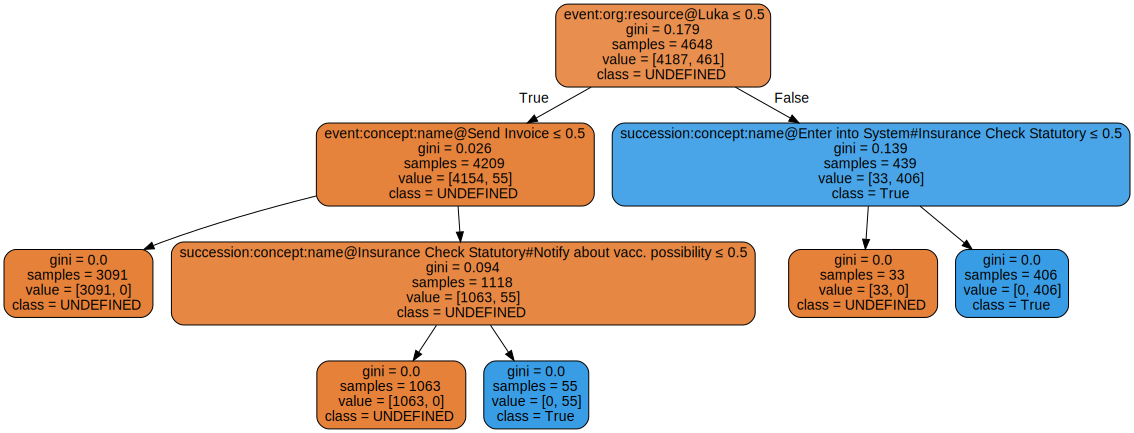

In [76]:
# show the resulted decision tree
gviz = dectree_visualizer.apply(clf, feature_names, classes)
gviz

In [77]:
# import graphviz
# dot_data = tree.export_graphviz(clf, out_file=None, feature_names=None, filled=True, rounded=True) 
# graph = graphviz.Source(dot_data)
# graph.render(view=True, format="png", filename="decisiontree_png")
# from pm4py.objects.log.exporter.xes import exporter as xes_exporter
# xes_exporter.apply(eventlog_4c, 'logs/log_4c.xes')